## 1. Environment Setup & Dependencies

### Required Libraries

```text
# requirements.txt
pandas>=1.5.0
numpy>=1.23.0
matplotlib>=3.6.0
seaborn>=0.12.0
yfinance>=0.2.0
scipy>=1.9.0
statsmodels>=0.14.0
```

**Installation:** Run `pip install -r requirements.txt` in your terminal before executing this notebook.

### Import & Configuration

In [19]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')  # Use Agg backend to avoid display issues
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from statsmodels.stats.weightstats import ttest_ind
import warnings
from datetime import datetime, timedelta
from IPython.display import display, Image

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)  # Reproducibility
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Professional plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print("✓ Environment configured successfully")
print(f"Pandas: {pd.__version__} | NumPy: {np.__version__}")

✓ Environment configured successfully
Pandas: 2.2.3 | NumPy: 1.26.4


## 2. Data Acquisition & Preprocessing

We'll use a diverse basket of 20 assets covering:
- Large-cap equities (tech, finance, consumer, energy)
- Sector ETFs
- International exposure
- Fixed income

**Data Period:** Last 10 years of daily adjusted close prices from Yahoo Finance (free source).

In [5]:
def get_price_data(tickers, start_date, end_date):
    """
    Download and clean price data for specified tickers.
    
    Parameters:
    -----------
    tickers : list
        List of ticker symbols
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with adjusted close prices, forward-filled for missing values
    """
    print(f"Downloading data for {len(tickers)} tickers from {start_date} to {end_date}...")
    
    # Download data - auto_adjust=False to get Adj Close column
    raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)
    
    # Extract Adj Close for each ticker
    if len(tickers) == 1:
        # Single ticker returns a simple DataFrame
        data = raw_data['Adj Close'].to_frame(name=tickers[0])
    else:
        # Multiple tickers - extract Adj Close for each
        data = pd.DataFrame()
        for ticker in tickers:
            try:
                data[ticker] = raw_data['Adj Close'][ticker]
            except KeyError:
                print(f"  Warning: {ticker} not found, skipping...")
                continue
    
    # Clean data: forward fill then backward fill missing values
    data = data.ffill().bfill()
    
    # Remove tickers with >20% missing data
    missing_pct = data.isna().sum() / len(data)
    valid_tickers = missing_pct[missing_pct < 0.20].index.tolist()
    data = data[valid_tickers]
    
    print(f"✓ Downloaded {len(data)} days for {len(valid_tickers)} tickers")
    print(f"  Date range: {data.index[0].date()} to {data.index[-1].date()}")
    
    return data


# Define universe: diverse basket of 20 assets
TICKERS = [
    # Large-cap tech
    'AAPL', 'MSFT', 'GOOGL', 'NVDA',
    # Finance & industrials
    'JPM', 'BAC', 'GE', 'BA',
    # Consumer & healthcare
    'AMZN', 'WMT', 'JNJ', 'PFE',
    # Energy & materials
    'XOM', 'CVX', 'FCX',
    # Sector ETFs
    'XLF', 'XLE', 'XLK', 'XLV',
    # Bond exposure
    'TLT'
]

# Date range: 10 years of data
END_DATE = datetime.now().strftime('%Y-%m-%d')
START_DATE = (datetime.now() - timedelta(days=365*10)).strftime('%Y-%m-%d')

# Download data
prices = get_price_data(TICKERS, START_DATE, END_DATE)

✓ Downloaded 2511 days for 20 tickers
  Date range: 2015-12-04 to 2025-11-28
✓ Downloaded 2511 days for 20 tickers
  Date range: 2015-12-04 to 2025-11-28


In [15]:
# Compute returns
returns = prices.pct_change()  # Simple returns
log_returns = np.log(prices / prices.shift(1))  # Log returns

# Drop first NaN row
returns = returns.dropna()
log_returns = log_returns.dropna()

print(f"\nReturns computed: {len(returns)} daily observations")
print(f"\nSummary statistics (annualized):")
print(f"Mean return: {returns.mean().mean() * 252:.2%}")
print(f"Mean volatility: {returns.std().mean() * np.sqrt(252):.2%}")

# Display first few rows
print("\nFirst 5 rows of price data:")
prices.head()


Returns computed: 2510 daily observations

Summary statistics (annualized):
Mean return: 19.74%
Mean volatility: 29.28%

First 5 rows of price data:


AAPL     MSFT    GOOGL    NVDA      JPM      BAC        GE  \
Date                                                                        
2015-12-04  26.8376  48.9554  38.6936  0.8233  51.8007  14.3711  128.3089   
2015-12-07  26.6685  48.8678  38.3848  0.8077  51.1216  14.1612  127.8039   
2015-12-08  26.6572  48.8503  38.4915  0.8187  50.3281  13.8787  127.0465   
2015-12-09  26.0687  48.1411  37.8663  0.7979  49.9466  13.8060  128.2248   
2015-12-10  26.1927  48.3950  37.7417  0.8045  50.0610  13.8867  128.9822   

                  BA     AMZN      WMT      JNJ      PFE      XOM      CVX  \
Date                                                                         
2015-12-04  133.1798  33.6320  16.6086  78.0461  20.2191  50.8888  58.4841   
2015-12-07  133.1349  33.4915  16.8425  78.3266  20.1328  49.5594  56.8999   
2015-12-08  130.0319  33.8665  16.5947  77.6443  20.0527  48.1591  56.3523   
2015-12-09  129.3593  33.2395  16.4611  77.4397  19.9048  48.8044  57.1085   
2015-12-10  131.3054  33.1160  16.5808  77.8111  19.9479  48.8431  58.2168   

               FCX      XLF      XLE      XLK      XLV      TLT  
Date                                                             
2015-12-04  7.1205  16.6635  43.0808  39.6839  60.7729  92.5354  
2015-12-07  6.5581  16.5088  41.4428  39.4880  60.4342  93.4333  
2015-12-08  6.1136  16.3004  41.0167  39.3901  60.5697  93.4794  
2015-12-09  6.3404  16.1121  41.5560  38.8114  59.9601  93.3796  
2015-12-10  6.6760  16.1255  41.8224  38.9182  60.4088  93.5024

## 3. Strategy Definitions

### 3.1 Time-Series Momentum (TSMOM)

**Logic:**
- For each asset independently, calculate past returns over a lookback window (e.g., 1M, 3M, 6M, 12M)
- **Long-Short variant:** +1 if past return > 0, -1 if < 0
- **Long-Only variant:** +1 if past return > 0, 0 otherwise
- Rebalance monthly (end of month)

**Intuition:** Trend-following on each asset's own history ("the trend is your friend")

In [7]:
def compute_tsmom_signals(prices, lookback_days, variant='longshort'):
    """
    Compute time-series momentum signals.
    
    Parameters:
    -----------
    prices : pd.DataFrame
        Price data (rows=dates, cols=assets)
    lookback_days : int
        Number of business days for lookback (21≈1M, 63≈3M, 126≈6M, 252≈12M)
    variant : str
        'longshort' (±1) or 'longonly' (0/+1)
        
    Returns:
    --------
    pd.DataFrame
        Signal matrix (1=long, -1=short, 0=neutral) resampled to month-end
    """
    # Calculate past returns
    past_returns = prices.pct_change(lookback_days)
    
    if variant == 'longshort':
        # +1 if positive past return, -1 if negative
        raw_signals = np.sign(past_returns)
    elif variant == 'longonly':
        # +1 if positive past return, 0 otherwise
        raw_signals = (past_returns > 0).astype(int)
    else:
        raise ValueError("variant must be 'longshort' or 'longonly'")
    
    # Resample to month-end (rebalance frequency)
    signals = raw_signals.resample('M').last()
    
    # Normalize to equal weight across active positions
    # Divide by number of non-zero positions to get equal weight
    for date in signals.index:
        active_positions = signals.loc[date].abs().sum()
        if active_positions > 0:
            signals.loc[date] = signals.loc[date] / active_positions
    
    return signals


# Example: 3-month lookback TSMOM
tsmom_3m_signals = compute_tsmom_signals(prices, lookback_days=63, variant='longshort')
print(f"TSMOM 3M Signals shape: {tsmom_3m_signals.shape}")
print(f"Average positions per month: {tsmom_3m_signals.abs().sum(axis=1).mean():.1f}")
tsmom_3m_signals.tail()

TSMOM 3M Signals shape: (120, 20)
Average positions per month: 1.0


AAPL  MSFT  GOOGL  NVDA   JPM   BAC    GE    BA  AMZN   WMT   JNJ  \
Date                                                                            
2025-07-31 -0.05  0.05   0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05   
2025-08-31  0.05  0.05   0.05  0.05  0.05  0.05  0.05  0.05  0.05 -0.05  0.05   
2025-09-30  0.05  0.05   0.05  0.05  0.05  0.05  0.05  0.05 -0.05  0.05  0.05   
2025-10-31  0.05 -0.05   0.05  0.05  0.05  0.05  0.05 -0.05  0.05  0.05  0.05   
2025-11-30  0.05 -0.05   0.05  0.05  0.05  0.05  0.05 -0.05  0.05  0.05  0.05   

             PFE   XOM   CVX   FCX   XLF   XLE   XLK   XLV   TLT  
Date                                                              
2025-07-31 -0.05  0.05  0.05  0.05  0.05  0.05  0.05 -0.05 -0.05  
2025-08-31  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  
2025-09-30  0.05  0.05  0.05 -0.05  0.05  0.05  0.05  0.05  0.05  
2025-10-31  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  
2025-11-30  0.05  0.05 -0.05 -0.05 -0.05  0.05  0.05  0.05  0.05

### 3.2 Cross-Sectional Momentum (XSMOM)

**Logic:**
- At each rebalance date, rank all assets by past return
- Go long top performers (e.g., top 20%) and short bottom performers (bottom 20%)
- Equal weight within long and short legs
- Portfolio is dollar-neutral (equal long/short exposure)

**Intuition:** Relative strength—bet on winners vs. losers regardless of absolute trends

In [8]:
def compute_xsmom_signals(prices, lookback_days, top_q=0.2, bottom_q=0.2):
    """
    Compute cross-sectional momentum signals.
    
    Parameters:
    -----------
    prices : pd.DataFrame
        Price data
    lookback_days : int
        Lookback window for ranking
    top_q : float
        Quantile threshold for long positions (e.g., 0.2 = top 20%)
    bottom_q : float
        Quantile threshold for short positions (e.g., 0.2 = bottom 20%)
        
    Returns:
    --------
    pd.DataFrame
        Signal matrix with equal weights for longs/shorts, resampled monthly
    """
    # Calculate past returns
    past_returns = prices.pct_change(lookback_days)
    
    # Resample to month-end first
    past_returns_monthly = past_returns.resample('M').last()
    
    signals = pd.DataFrame(0, index=past_returns_monthly.index, columns=past_returns_monthly.columns)
    
    for date in signals.index:
        returns_t = past_returns_monthly.loc[date].dropna()
        
        if len(returns_t) < 5:  # Need minimum assets
            continue
        
        # Determine thresholds
        top_threshold = returns_t.quantile(1 - top_q)
        bottom_threshold = returns_t.quantile(bottom_q)
        
        # Long top performers
        longs = returns_t[returns_t >= top_threshold].index
        # Short bottom performers
        shorts = returns_t[returns_t <= bottom_threshold].index
        
        # Equal weight within legs
        if len(longs) > 0:
            signals.loc[date, longs] = 1.0 / len(longs)
        if len(shorts) > 0:
            signals.loc[date, shorts] = -1.0 / len(shorts)
    
    return signals


# Example: 3-month lookback XSMOM
xsmom_3m_signals = compute_xsmom_signals(prices, lookback_days=63, top_q=0.2, bottom_q=0.2)
print(f"XSMOM 3M Signals shape: {xsmom_3m_signals.shape}")
print(f"Average long positions: {(xsmom_3m_signals > 0).sum(axis=1).mean():.1f}")
print(f"Average short positions: {(xsmom_3m_signals < 0).sum(axis=1).mean():.1f}")
xsmom_3m_signals.tail()

XSMOM 3M Signals shape: (120, 20)
Average long positions: 3.9
Average short positions: 3.9


AAPL  MSFT  GOOGL  NVDA  JPM   BAC    GE    BA  AMZN   WMT   JNJ  \
Date                                                                           
2025-07-31 -0.25  0.25   0.00  0.25  0.0  0.00  0.25  0.00  0.25  0.00  0.00   
2025-08-31  0.00  0.00   0.25  0.25  0.0  0.00  0.00  0.00  0.00 -0.25  0.00   
2025-09-30  0.25  0.00   0.25  0.25  0.0  0.00  0.25  0.00 -0.25  0.00  0.00   
2025-10-31  0.25 -0.25   0.25  0.00  0.0  0.25  0.00 -0.25  0.25 -0.25  0.00   
2025-11-30  0.25 -0.25   0.25  0.00  0.0  0.00  0.00 -0.25  0.00  0.00  0.25   

             PFE  XOM   CVX   FCX   XLF  XLE  XLK   XLV   TLT  
Date                                                           
2025-07-31 -0.25  0.0  0.00  0.00  0.00  0.0  0.0 -0.25 -0.25  
2025-08-31  0.00  0.0  0.25  0.25 -0.25  0.0  0.0 -0.25 -0.25  
2025-09-30  0.00  0.0  0.00 -0.25  0.00  0.0  0.0 -0.25 -0.25  
2025-10-31  0.00  0.0  0.00  0.00 -0.25  0.0  0.0  0.00  0.00  
2025-11-30  0.00  0.0 -0.25 -0.25  0.00  0.0  0.0  0.25  0.00

## 4. Backtesting Framework

Vectorized monthly rebalancing with:
- Forward-looking return calculation (no lookahead bias)
- Transaction cost modeling (basis points per turnover)
- Turnover calculation
- Portfolio return aggregation

In [16]:
def backtest_signals(signals, returns, tc_bps=10):
    """
    Backtest a signal matrix against forward returns.
    
    Parameters:
    -----------
    signals : pd.DataFrame
        Position signals (monthly frequency)
    returns : pd.DataFrame
        Daily returns
    tc_bps : float
        Transaction cost in basis points (applied to turnover)
        
    Returns:
    --------
    dict
        Dictionary containing portfolio returns, turnover, and wealth index
    """
    # Align signals and returns
    signals = signals.reindex(returns.index, method='ffill')
    
    # Calculate portfolio returns (position * next period return)
    portfolio_returns = (signals.shift(1) * returns).sum(axis=1)
    
    # Calculate turnover (sum of absolute changes in positions)
    position_changes = signals.diff().abs().sum(axis=1)
    monthly_turnover = position_changes.resample('M').sum()
    
    # Apply transaction costs
    tc_daily = position_changes * (tc_bps / 10000)  # Convert bps to decimal
    portfolio_returns_net = portfolio_returns - tc_daily
    
    # Calculate cumulative returns (wealth index)
    wealth_index = (1 + portfolio_returns_net).cumprod()
    
    return {
        'returns': portfolio_returns_net.dropna(),
        'returns_gross': portfolio_returns.dropna(),
        'turnover': monthly_turnover,
        'wealth_index': wealth_index,
        'signals': signals
    }


def calculate_performance_metrics(returns, rf_rate=0.0):
    """
    Calculate comprehensive performance metrics.
    
    Parameters:
    -----------
    returns : pd.Series
        Daily returns
    rf_rate : float
        Annual risk-free rate (default 0)
        
    Returns:
    --------
    dict
        Dictionary of performance metrics
    """
    # Annualization factor
    ann_factor = 252
    
    # CAGR
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / ann_factor
    cagr = (1 + total_return) ** (1 / n_years) - 1
    
    # Volatility
    vol = returns.std() * np.sqrt(ann_factor)
    
    # Sharpe ratio
    excess_returns = returns - rf_rate / ann_factor
    sharpe = excess_returns.mean() / returns.std() * np.sqrt(ann_factor) if returns.std() > 0 else 0
    
    # Maximum drawdown
    wealth_index = (1 + returns).cumprod()
    running_max = wealth_index.expanding().max()
    drawdown = (wealth_index - running_max) / running_max
    max_dd = drawdown.min()
    
    # Calmar ratio
    calmar = cagr / abs(max_dd) if max_dd != 0 else 0
    
    # Win rate
    win_rate = (returns > 0).sum() / len(returns)
    
    return {
        'CAGR': cagr,
        'Volatility': vol,
        'Sharpe': sharpe,
        'Max DD': max_dd,
        'Calmar': calmar,
        'Win Rate': win_rate,
        'Total Return': total_return
    }


print("✓ Backtesting framework ready")

✓ Backtesting framework ready


## 5. Strategy Comparison Across Lookback Windows

We'll test both TSMOM and XSMOM across multiple lookback periods:
- 1-month (21 days)
- 3-month (63 days)
- 6-month (126 days)
- 12-month (252 days)

In [17]:
# Define lookback windows
LOOKBACKS = {
    '1M': 21,
    '3M': 63,
    '6M': 126,
    '12M': 252
}

# Transaction cost assumption (10 bps per trade)
TC_BPS = 10

# Storage for results
results = {}
backtest_results = {}

print("Running backtests across all lookback windows...\n")

# Benchmark: Equal-weight buy & hold
benchmark_returns = returns.mean(axis=1)
benchmark_metrics = calculate_performance_metrics(benchmark_returns)
results['Benchmark (EW)'] = benchmark_metrics
backtest_results['Benchmark (EW)'] = {
    'returns': benchmark_returns,
    'wealth_index': (1 + benchmark_returns).cumprod(),
    'turnover': pd.Series(0, index=returns.resample('M').last().index)
}

# Run TSMOM strategies
for name, days in LOOKBACKS.items():
    print(f"  TSMOM {name}...", end=' ')
    
    # Long-short variant
    signals = compute_tsmom_signals(prices, days, variant='longshort')
    bt_result = backtest_signals(signals, returns, tc_bps=TC_BPS)
    metrics = calculate_performance_metrics(bt_result['returns'])
    
    strategy_name = f'TSMOM {name} (LS)'
    results[strategy_name] = metrics
    backtest_results[strategy_name] = bt_result
    
    print(f"Sharpe: {metrics['Sharpe']:.2f}")

# Run XSMOM strategies
for name, days in LOOKBACKS.items():
    print(f"  XSMOM {name}...", end=' ')
    
    signals = compute_xsmom_signals(prices, days, top_q=0.2, bottom_q=0.2)
    bt_result = backtest_signals(signals, returns, tc_bps=TC_BPS)
    metrics = calculate_performance_metrics(bt_result['returns'])
    
    strategy_name = f'XSMOM {name}'
    results[strategy_name] = metrics
    backtest_results[strategy_name] = bt_result
    
    print(f"Sharpe: {metrics['Sharpe']:.2f}")

print("\n✓ All backtests completed")

Running backtests across all lookback windows...

  TSMOM 1M... Sharpe: 0.05
  TSMOM 3M... Sharpe: 0.41
  TSMOM 6M... Sharpe: 0.56
  TSMOM 12M... Sharpe: 0.42
  XSMOM 1M... Sharpe: 0.26
  XSMOM 3M... Sharpe: 0.26
  XSMOM 3M... Sharpe: 0.43
  XSMOM 6M... Sharpe: 0.43
  XSMOM 6M... Sharpe: 0.51
  XSMOM 12M... Sharpe: 0.73

✓ All backtests completed
Sharpe: 0.51
  XSMOM 12M... Sharpe: 0.73

✓ All backtests completed


## 6. Performance Metrics & Statistical Analysis

In [11]:
# Create comprehensive results table
results_df = pd.DataFrame(results).T

# Format for display
results_display = results_df.copy()
results_display['CAGR'] = results_display['CAGR'].map('{:.2%}'.format)
results_display['Volatility'] = results_display['Volatility'].map('{:.2%}'.format)
results_display['Sharpe'] = results_display['Sharpe'].map('{:.2f}'.format)
results_display['Max DD'] = results_display['Max DD'].map('{:.2%}'.format)
results_display['Calmar'] = results_display['Calmar'].map('{:.2f}'.format)
results_display['Win Rate'] = results_display['Win Rate'].map('{:.2%}'.format)
results_display['Total Return'] = results_display['Total Return'].map('{:.2%}'.format)

print("\n" + "="*80)
print("PERFORMANCE COMPARISON: TSMOM vs XSMOM vs BENCHMARK")
print("="*80)
print(results_display.to_string())
print("\nNote: Transaction costs = 10 bps per trade | Risk-free rate = 0%")


PERFORMANCE COMPARISON: TSMOM vs XSMOM vs BENCHMARK
                  CAGR Volatility Sharpe   Max DD Calmar Win Rate Total Return
Benchmark (EW)  19.61%     19.10%   1.03  -36.35%   0.54   55.94%      495.00%
TSMOM 1M (LS)   -0.30%     13.77%   0.05  -41.43%  -0.01   51.12%       -2.96%
TSMOM 3M (LS)    4.38%     12.12%   0.41  -25.90%   0.17   51.55%       53.25%
TSMOM 6M (LS)    6.04%     11.58%   0.56  -28.77%   0.21   50.00%       79.39%
TSMOM 12M (LS)   4.19%     11.44%   0.42  -24.84%   0.17   47.93%       50.57%
XSMOM 1M         3.49%     25.49%   0.26  -44.17%   0.08   50.84%       40.77%
XSMOM 3M         8.64%     28.62%   0.43  -42.49%   0.20   50.28%      128.20%
XSMOM 6M        10.91%     27.99%   0.51  -38.44%   0.28   49.32%      180.54%
XSMOM 12M       17.59%     27.49%   0.73  -40.13%   0.44   47.81%      402.37%

Note: Transaction costs = 10 bps per trade | Risk-free rate = 0%


In [12]:
# Calculate average turnover for each strategy
turnover_summary = {}
for strategy_name, bt_result in backtest_results.items():
    if 'turnover' in bt_result:
        avg_monthly_turnover = bt_result['turnover'].mean()
        turnover_summary[strategy_name] = avg_monthly_turnover

turnover_df = pd.DataFrame.from_dict(turnover_summary, orient='index', columns=['Avg Monthly Turnover'])
turnover_df['Turnover %'] = turnover_df['Avg Monthly Turnover'].map('{:.1%}'.format)

print("\n" + "="*60)
print("TURNOVER ANALYSIS")
print("="*60)
print(turnover_df[['Turnover %']].to_string())
print("\nNote: Higher turnover = higher transaction costs")


TURNOVER ANALYSIS
               Turnover %
Benchmark (EW)       0.0%
TSMOM 1M (LS)       92.0%
TSMOM 3M (LS)       45.6%
TSMOM 6M (LS)       32.0%
TSMOM 12M (LS)      19.7%
XSMOM 1M           285.0%
XSMOM 3M           170.4%
XSMOM 6M           115.8%
XSMOM 12M           65.0%

Note: Higher turnover = higher transaction costs


In [13]:
# Statistical significance tests: TSMOM vs XSMOM for 3M lookback
tsmom_3m_returns = backtest_results['TSMOM 3M (LS)']['returns']
xsmom_3m_returns = backtest_results['XSMOM 3M']['returns']

# T-test for difference in means
t_stat, p_value, _ = ttest_ind(tsmom_3m_returns, xsmom_3m_returns)

print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TEST (3M Lookback)")
print("="*60)
print(f"TSMOM 3M vs XSMOM 3M")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant at 5% level: {'Yes' if p_value < 0.05 else 'No'}")
print("\nInterpretation: p-value < 0.05 suggests statistically significant difference in returns")


STATISTICAL SIGNIFICANCE TEST (3M Lookback)
TSMOM 3M vs XSMOM 3M
  t-statistic: -0.749
  p-value: 0.4541
  Significant at 5% level: No

Interpretation: p-value < 0.05 suggests statistically significant difference in returns


## 7. Visualizations

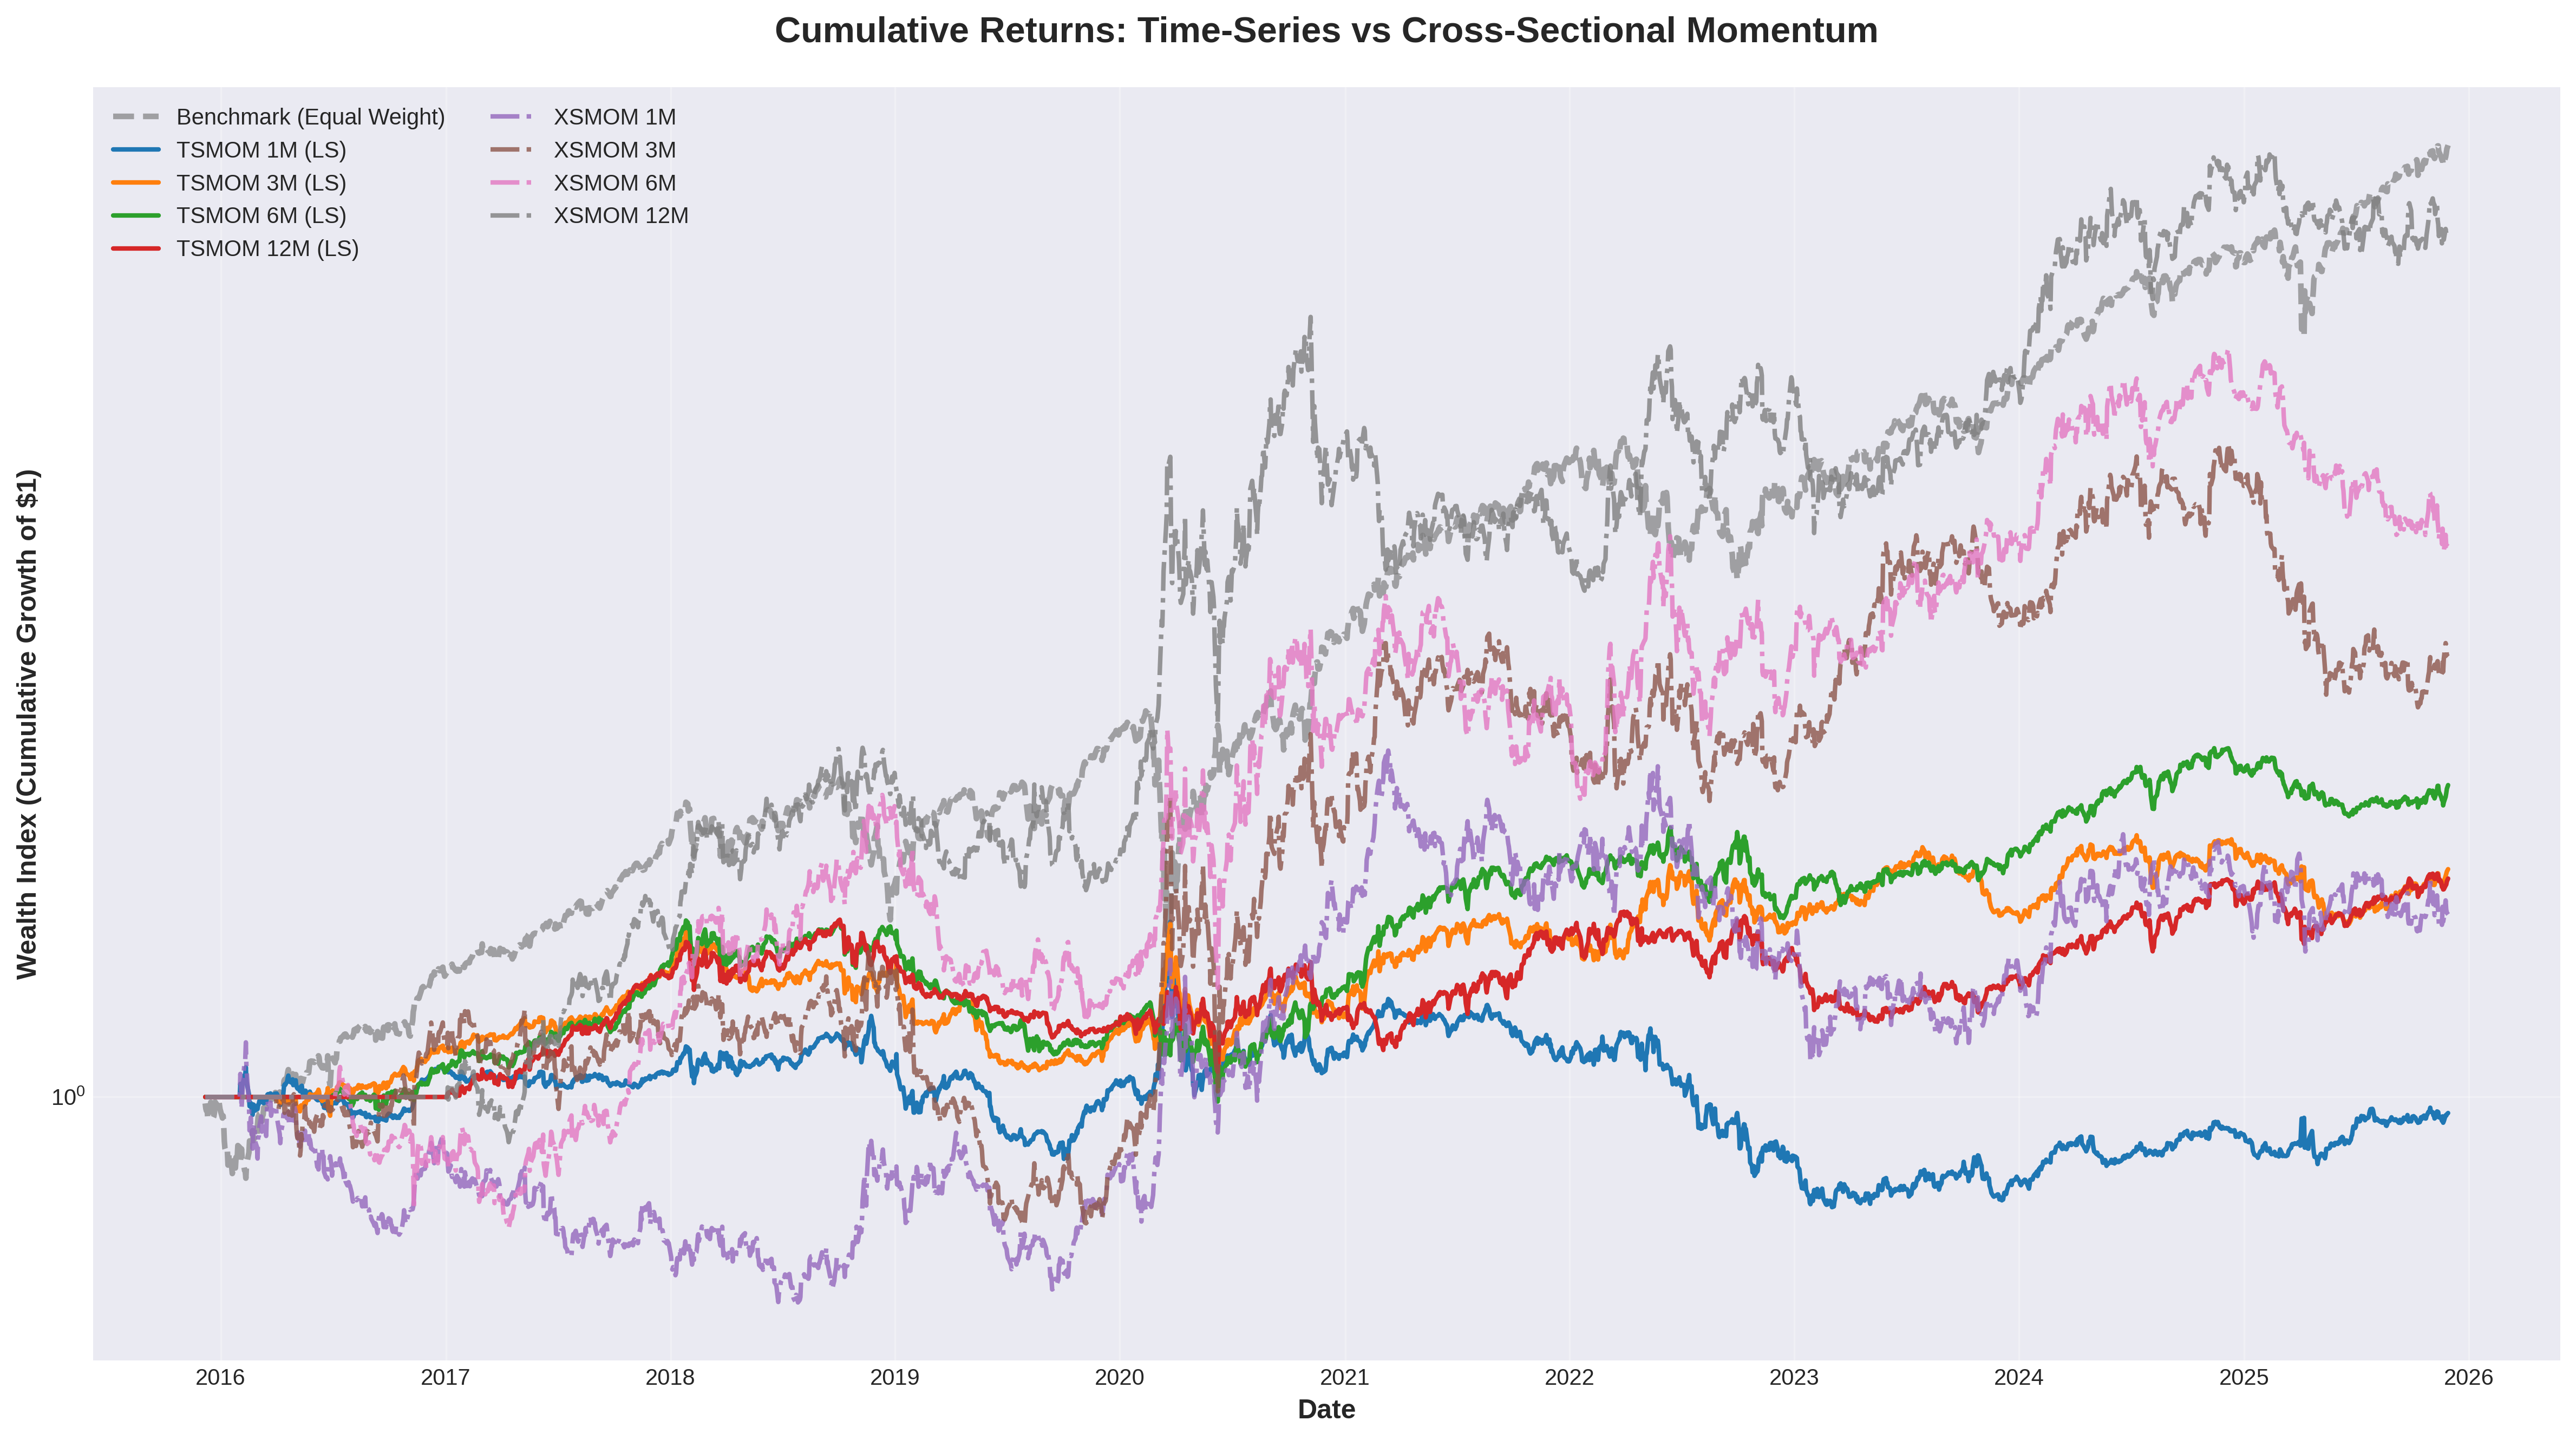

✓ Cumulative returns chart saved and displayed


In [20]:
# 7.1 Cumulative Returns Comparison
fig, ax = plt.subplots(figsize=(16, 9))

# Plot benchmark
benchmark_wealth = backtest_results['Benchmark (EW)']['wealth_index']
ax.plot(benchmark_wealth.index, benchmark_wealth.values, 
        label='Benchmark (Equal Weight)', linewidth=2.5, linestyle='--', color='gray', alpha=0.7)

# Plot TSMOM strategies
colors_tsmom = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, (name, days) in enumerate(LOOKBACKS.items()):
    strategy_name = f'TSMOM {name} (LS)'
    wealth = backtest_results[strategy_name]['wealth_index']
    ax.plot(wealth.index, wealth.values, label=strategy_name, linewidth=2, color=colors_tsmom[i])

# Plot XSMOM strategies
colors_xsmom = ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
for i, (name, days) in enumerate(LOOKBACKS.items()):
    strategy_name = f'XSMOM {name}'
    wealth = backtest_results[strategy_name]['wealth_index']
    ax.plot(wealth.index, wealth.values, label=strategy_name, linewidth=2, 
            linestyle='-.', color=colors_xsmom[i], alpha=0.8)

ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Wealth Index (Cumulative Growth of $1)', fontweight='bold')
ax.set_title('Cumulative Returns: Time-Series vs Cross-Sectional Momentum', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.savefig('cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.close()

# Display the image inline
display(Image('cumulative_returns.png'))
print("✓ Cumulative returns chart saved and displayed")

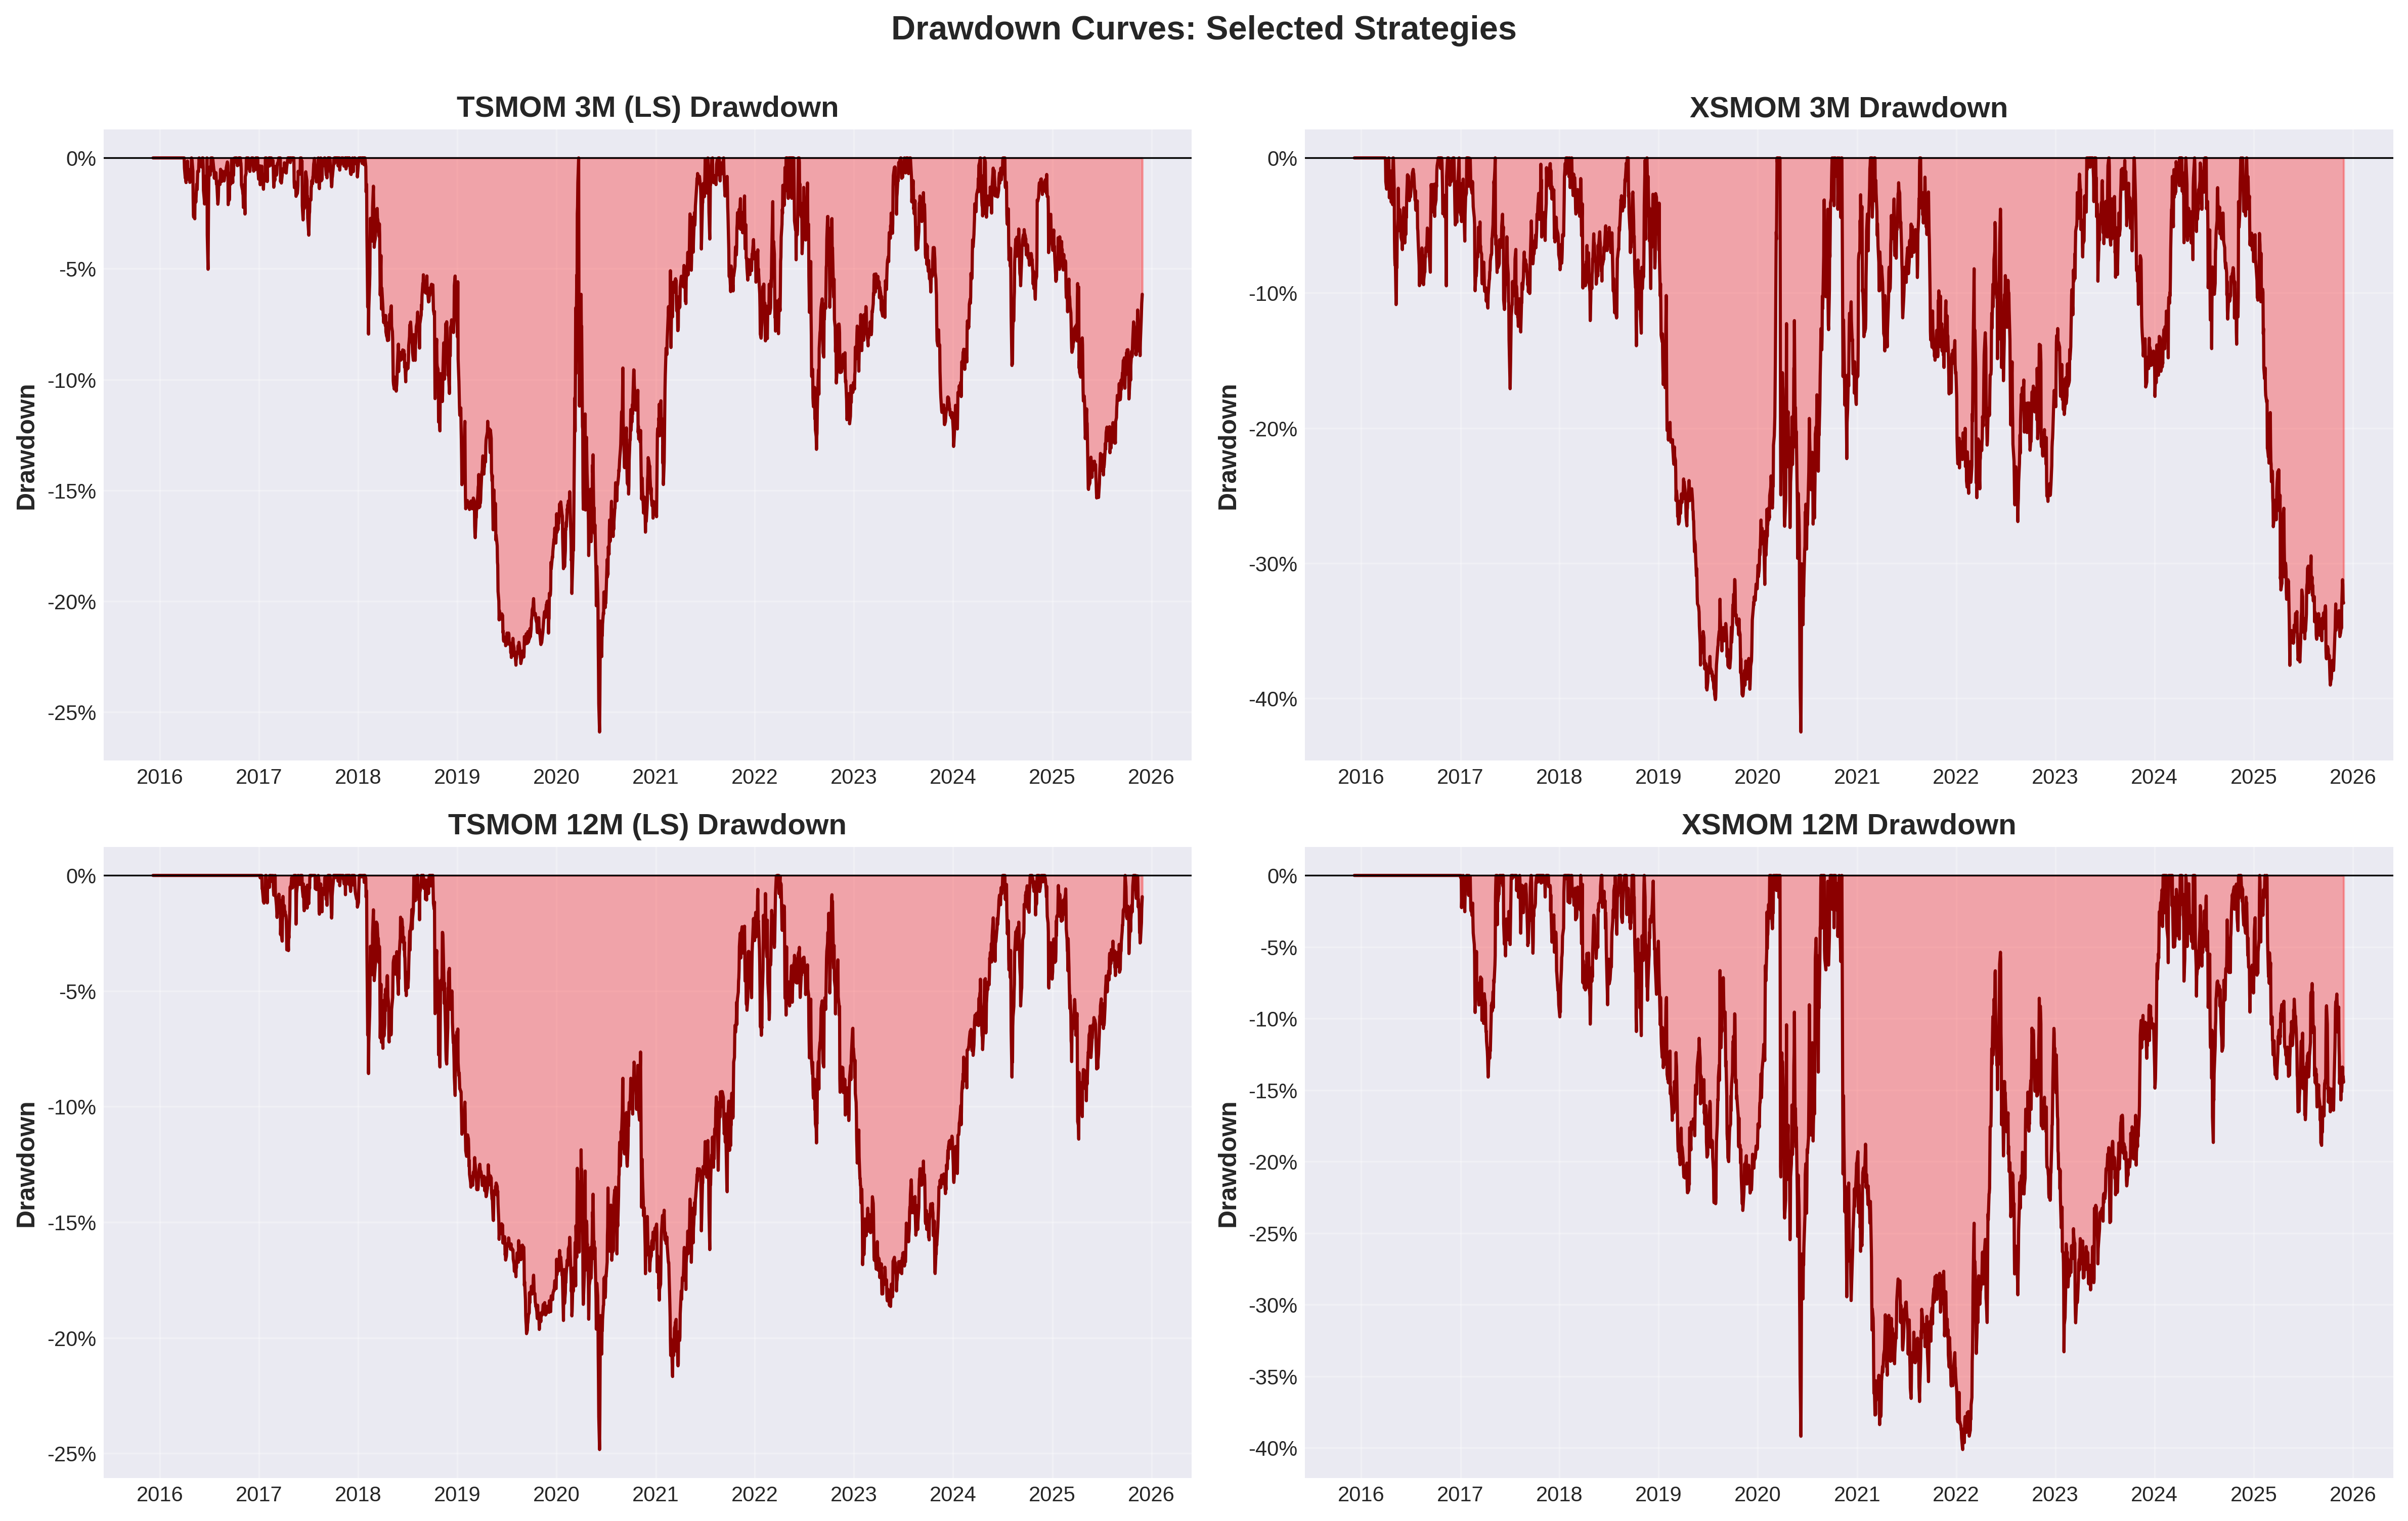

✓ Drawdown analysis saved and displayed


In [26]:
# 7.2 Drawdown Analysis
def calculate_drawdown(returns):
    """Calculate drawdown series from returns."""
    wealth_index = (1 + returns).cumprod()
    running_max = wealth_index.expanding().max()
    drawdown = (wealth_index - running_max) / running_max
    return drawdown

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

strategies_to_plot = [
    'TSMOM 3M (LS)',
    'XSMOM 3M',
    'TSMOM 12M (LS)',
    'XSMOM 12M'
]

for i, strategy in enumerate(strategies_to_plot):
    returns = backtest_results[strategy]['returns']
    dd = calculate_drawdown(returns)
    
    axes[i].fill_between(dd.index, dd.values, 0, alpha=0.3, color='red')
    axes[i].plot(dd.index, dd.values, color='darkred', linewidth=1.5)
    axes[i].set_title(f'{strategy} Drawdown', fontweight='bold')
    axes[i].set_ylabel('Drawdown', fontweight='bold')
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

plt.suptitle('Drawdown Curves: Selected Strategies', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('drawdown_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# Display the image inline
display(Image('drawdown_analysis.png'))
print("✓ Drawdown analysis saved and displayed")

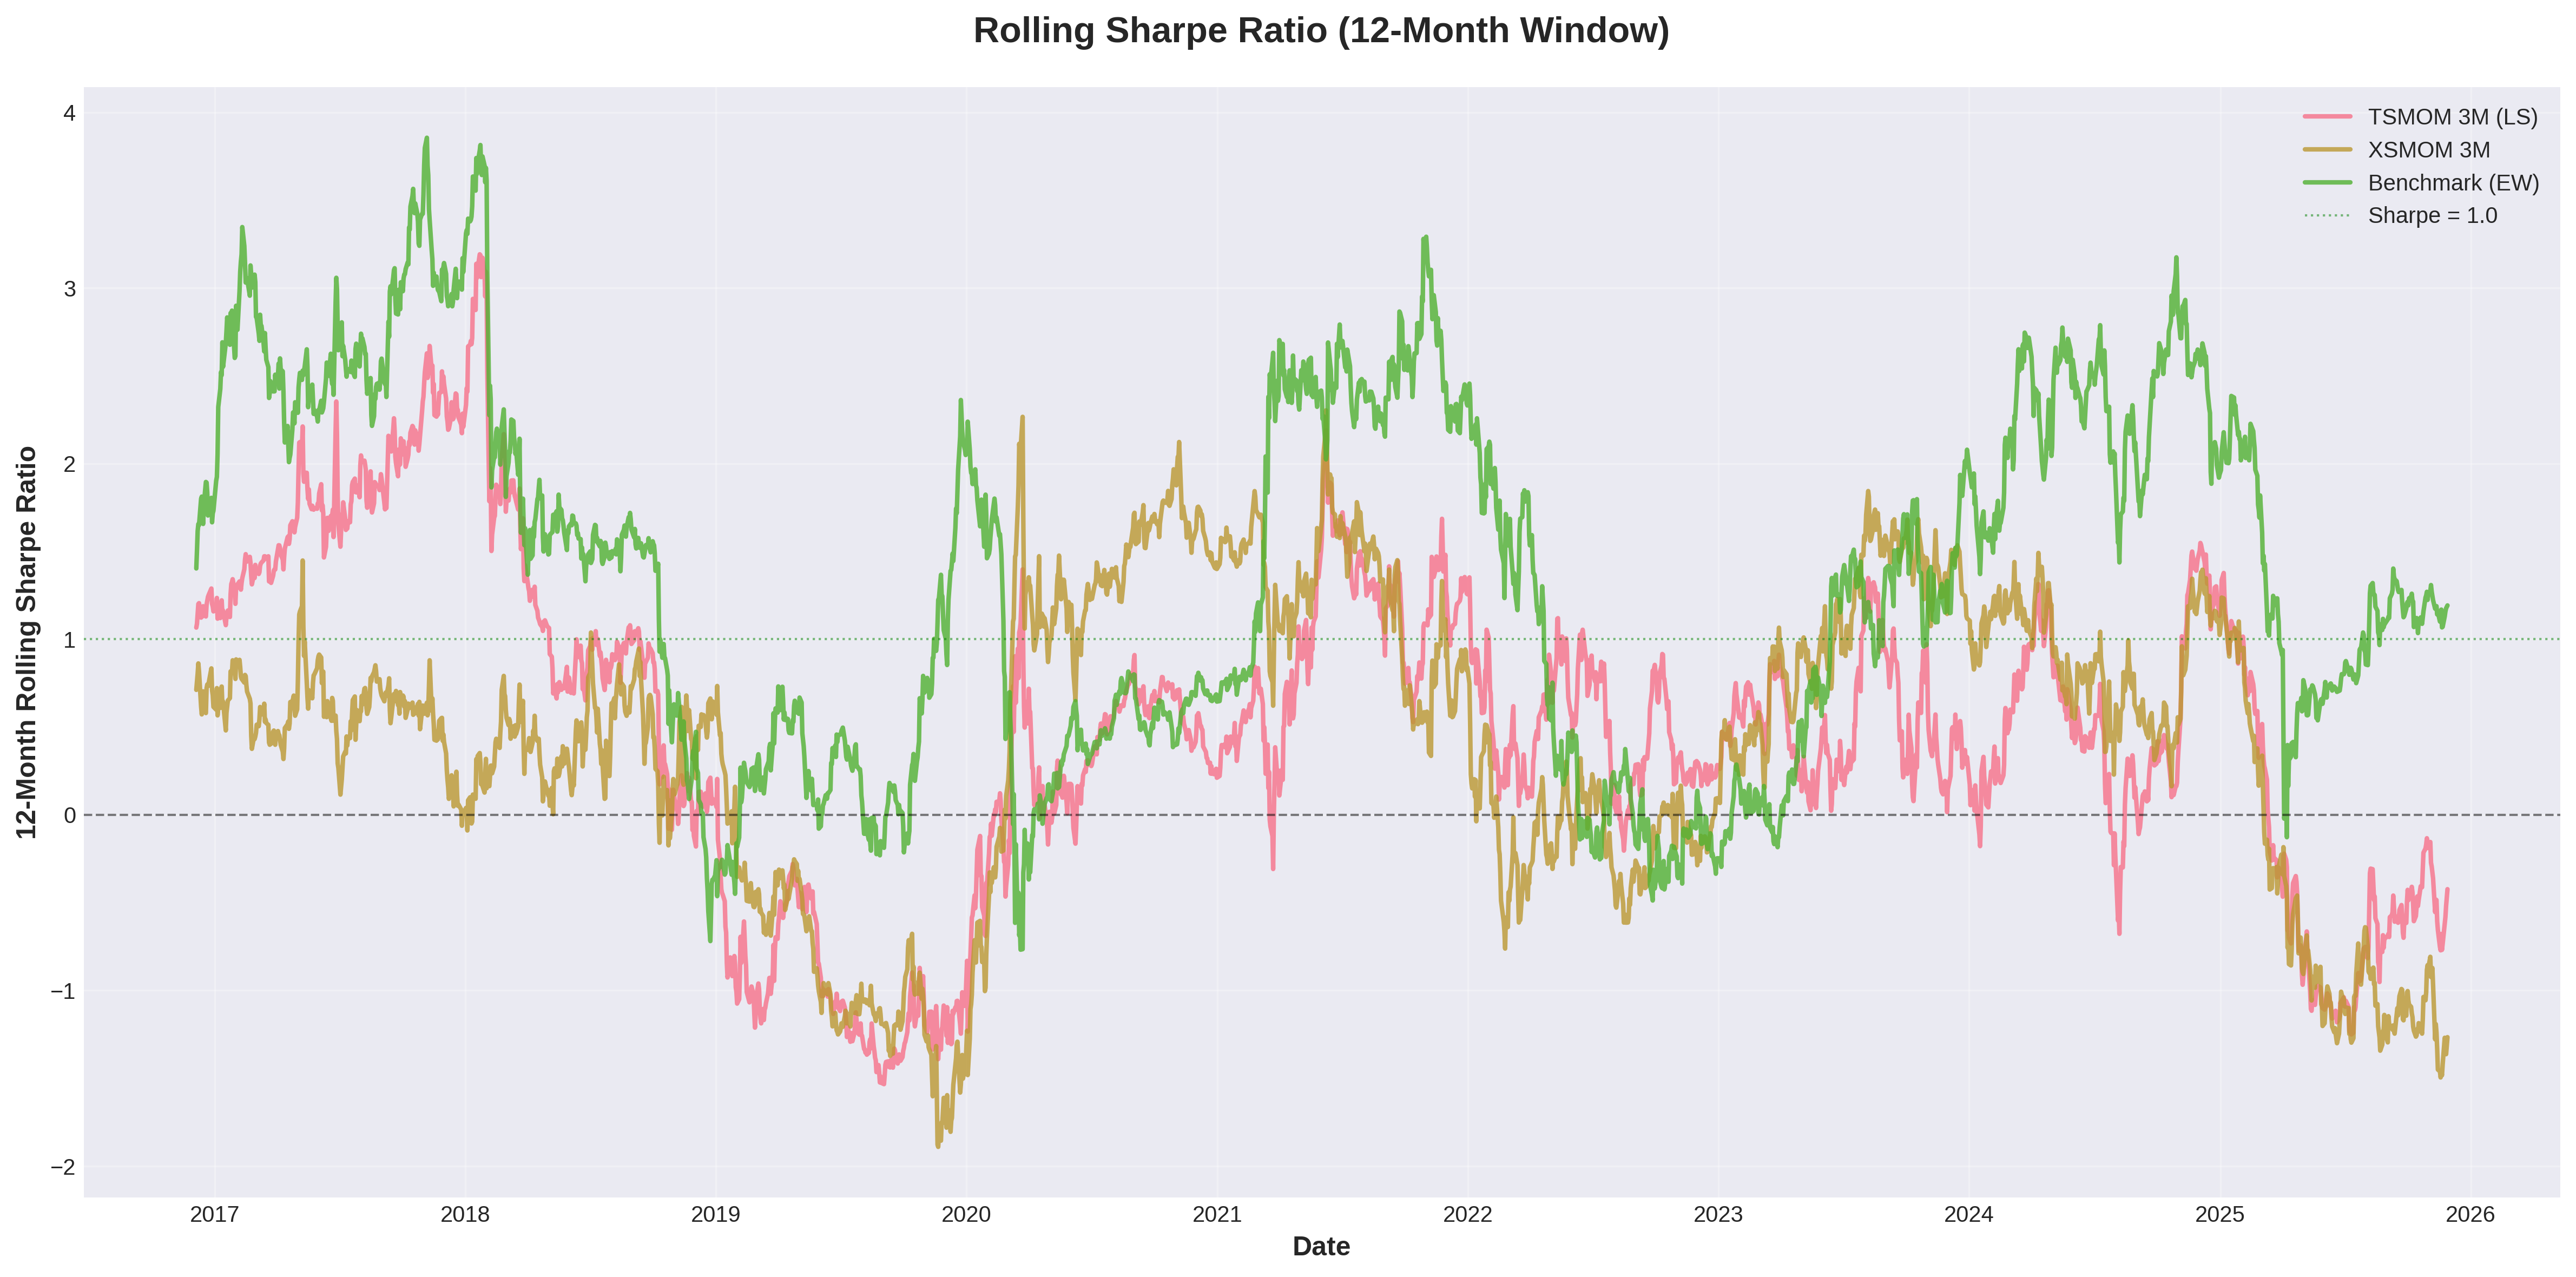

✓ Rolling Sharpe chart saved and displayed


In [27]:
# 7.3 Rolling Sharpe Ratio (12-month window)
fig, ax = plt.subplots(figsize=(16, 8))

window = 252  # 12-month rolling

for strategy in ['TSMOM 3M (LS)', 'XSMOM 3M', 'Benchmark (EW)']:
    returns = backtest_results[strategy]['returns']
    rolling_sharpe = returns.rolling(window).mean() / returns.rolling(window).std() * np.sqrt(252)
    ax.plot(rolling_sharpe.index, rolling_sharpe.values, label=strategy, linewidth=2, alpha=0.8)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(y=1, color='green', linestyle=':', linewidth=1, alpha=0.5, label='Sharpe = 1.0')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('12-Month Rolling Sharpe Ratio', fontweight='bold')
ax.set_title('Rolling Sharpe Ratio (12-Month Window)', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', framealpha=0.95)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rolling_sharpe.png', dpi=300, bbox_inches='tight')
plt.close()

# Display the image inline

display(Image('rolling_sharpe.png'))
print("✓ Rolling Sharpe chart saved and displayed")

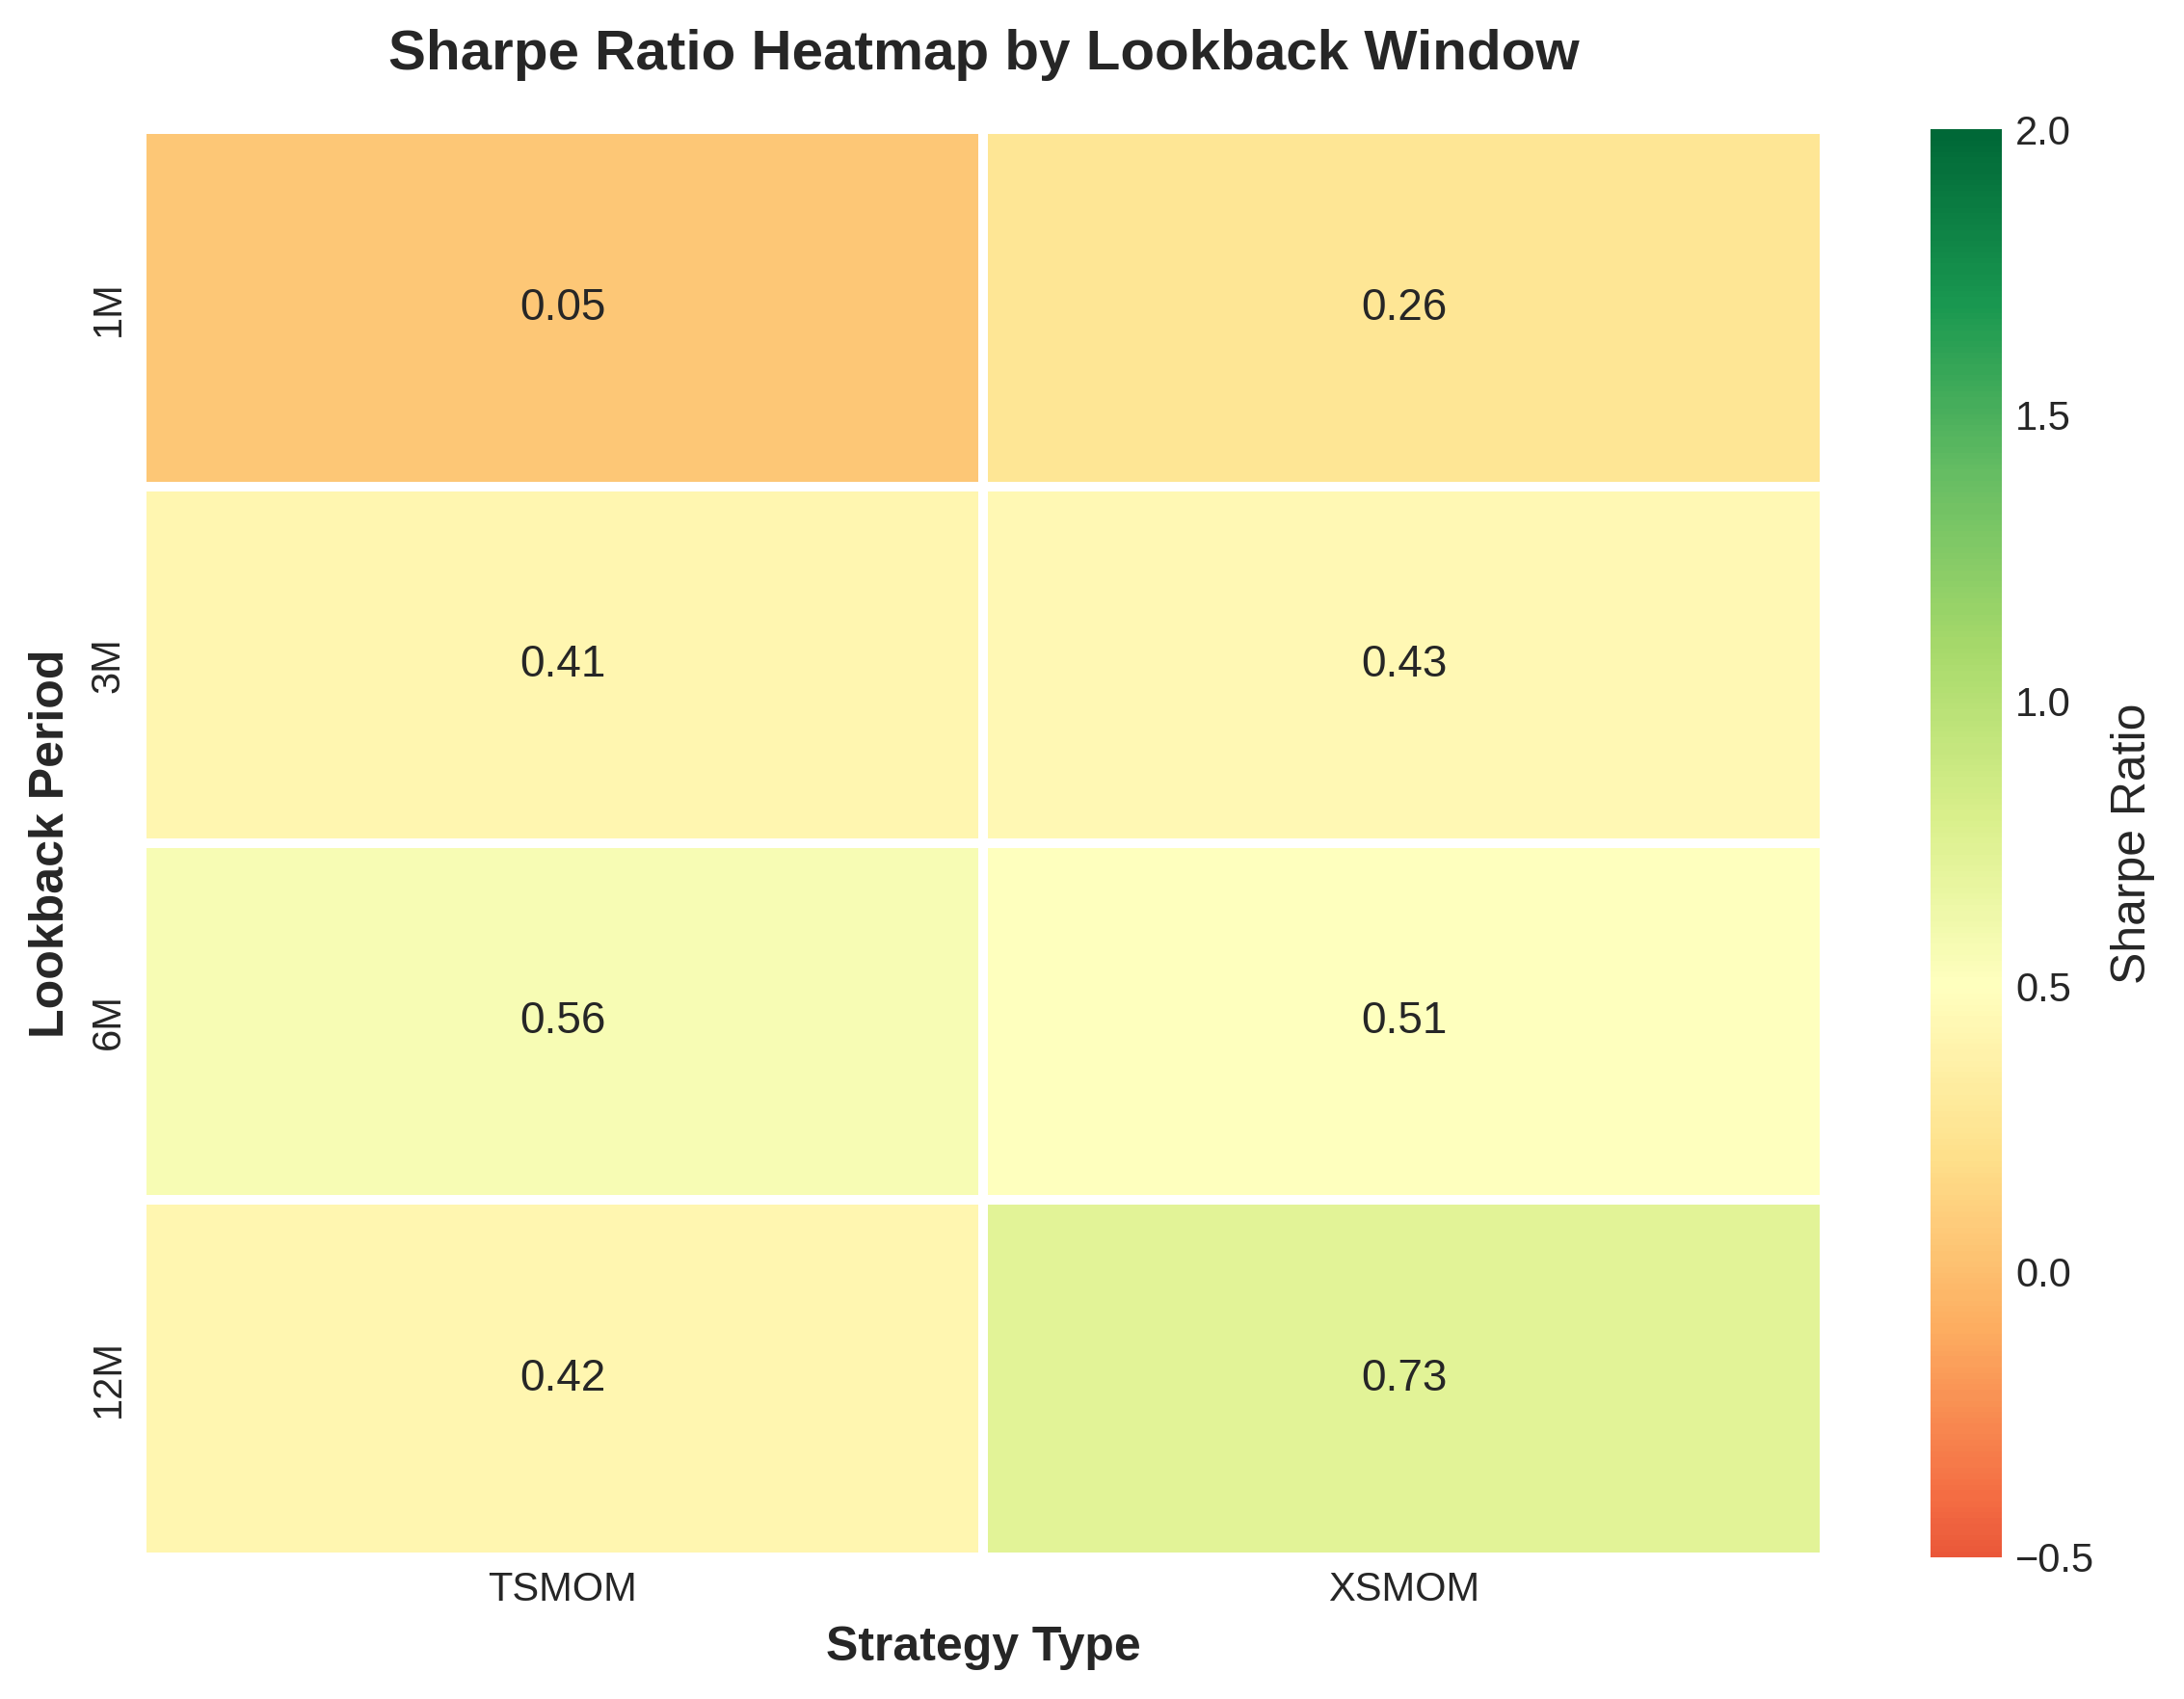

✓ Sharpe heatmap saved and displayed


In [28]:
# 7.4 Performance Heatmap: Sharpe Ratios
sharpe_matrix = results_df['Sharpe'].copy()

# Separate TSMOM and XSMOM
tsmom_sharpes = {k.split()[1]: v for k, v in sharpe_matrix.items() if 'TSMOM' in k}
xsmom_sharpes = {k.split()[1]: v for k, v in sharpe_matrix.items() if 'XSMOM' in k}

heatmap_data = pd.DataFrame({
    'TSMOM': [tsmom_sharpes.get(k, np.nan) for k in LOOKBACKS.keys()],
    'XSMOM': [xsmom_sharpes.get(k, np.nan) for k in LOOKBACKS.keys()]
}, index=LOOKBACKS.keys())

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', center=0.5,
            linewidths=2, cbar_kws={'label': 'Sharpe Ratio'}, ax=ax,
            vmin=-0.5, vmax=2.0)
ax.set_title('Sharpe Ratio Heatmap by Lookback Window', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Strategy Type', fontweight='bold')
ax.set_ylabel('Lookback Period', fontweight='bold')
plt.tight_layout()
plt.savefig('sharpe_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

# Display the image inline

display(Image('sharpe_heatmap.png'))
print("✓ Sharpe heatmap saved and displayed")

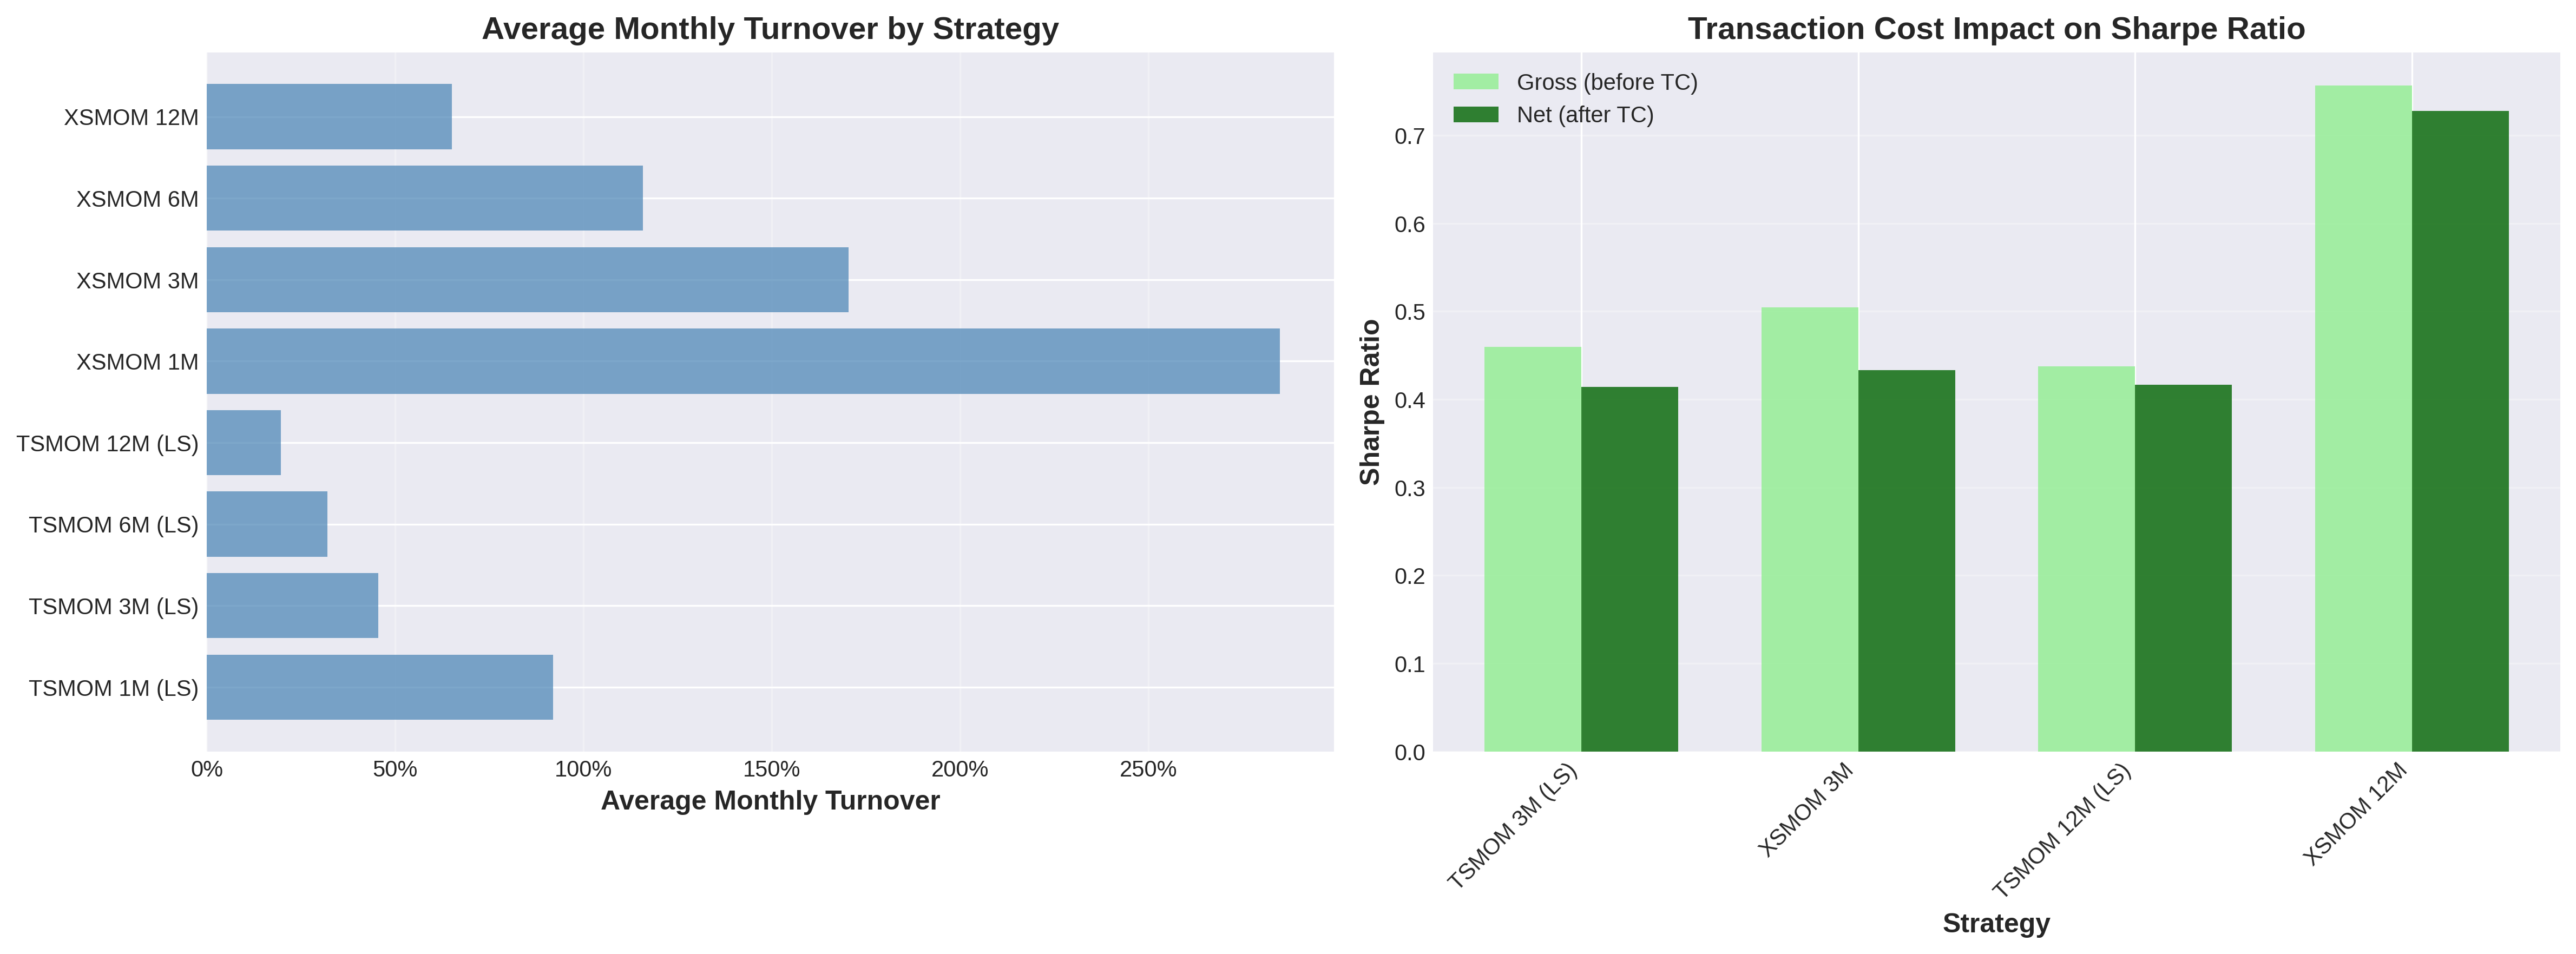

✓ Turnover & TC analysis saved and displayed


In [30]:
# 7.5 Turnover & Transaction Cost Impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Average monthly turnover
strategies_turnover = [k for k in turnover_summary.keys() if k != 'Benchmark (EW)']
turnover_values = [turnover_summary[k] for k in strategies_turnover]

ax1.barh(strategies_turnover, turnover_values, color='steelblue', alpha=0.7)
ax1.set_xlabel('Average Monthly Turnover', fontweight='bold')
ax1.set_title('Average Monthly Turnover by Strategy', fontsize=14, fontweight='bold')
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax1.grid(axis='x', alpha=0.3)

# Transaction cost impact (gross vs net Sharpe)
sharpe_comparison = []
for strategy in ['TSMOM 3M (LS)', 'XSMOM 3M', 'TSMOM 12M (LS)', 'XSMOM 12M']:
    gross_returns = backtest_results[strategy]['returns_gross']
    net_returns = backtest_results[strategy]['returns']
    
    sharpe_gross = calculate_performance_metrics(gross_returns)['Sharpe']
    sharpe_net = calculate_performance_metrics(net_returns)['Sharpe']
    
    sharpe_comparison.append({
        'Strategy': strategy,
        'Gross Sharpe': sharpe_gross,
        'Net Sharpe': sharpe_net
    })

sharpe_comp_df = pd.DataFrame(sharpe_comparison)
x = np.arange(len(sharpe_comp_df))
width = 0.35

ax2.bar(x - width/2, sharpe_comp_df['Gross Sharpe'], width, label='Gross (before TC)', color='lightgreen', alpha=0.8)
ax2.bar(x + width/2, sharpe_comp_df['Net Sharpe'], width, label='Net (after TC)', color='darkgreen', alpha=0.8)
ax2.set_xlabel('Strategy', fontweight='bold')
ax2.set_ylabel('Sharpe Ratio', fontweight='bold')
ax2.set_title('Transaction Cost Impact on Sharpe Ratio', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sharpe_comp_df['Strategy'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('turnover_tc_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# Display the image inline

display(Image('turnover_tc_analysis.png'))
print("✓ Turnover & TC analysis saved and displayed")

## 8. Export Results for Sharing

In [31]:
# Export results summary as CSV
results_df.to_csv('results_summary.csv')
print("✓ Results exported to 'results_summary.csv'")

# Export turnover analysis
turnover_df.to_csv('turnover_summary.csv')
print("✓ Turnover data exported to 'turnover_summary.csv'")

print("\n" + "="*60)
print("ALL DELIVERABLES READY")
print("="*60)
print("📊 Charts generated:")
print("  - cumulative_returns.png")
print("  - drawdown_analysis.png")
print("  - rolling_sharpe.png")
print("  - sharpe_heatmap.png")
print("  - turnover_tc_analysis.png")
print("\n📁 Data files:")
print("  - results_summary.csv")
print("  - turnover_summary.csv")
print("\n📝 To export notebook as HTML for sharing:")
print("  Run: jupyter nbconvert --to html time_series_vs_cross_sectional_momentum.ipynb")
print("\n✓ Analysis complete! Ready for LinkedIn post.")

✓ Results exported to 'results_summary.csv'
✓ Turnover data exported to 'turnover_summary.csv'

ALL DELIVERABLES READY
📊 Charts generated:
  - cumulative_returns.png
  - drawdown_analysis.png
  - rolling_sharpe.png
  - sharpe_heatmap.png
  - turnover_tc_analysis.png

📁 Data files:
  - results_summary.csv
  - turnover_summary.csv

📝 To export notebook as HTML for sharing:
  Run: jupyter nbconvert --to html time_series_vs_cross_sectional_momentum.ipynb

✓ Analysis complete! Ready for LinkedIn post.


---
### Final Disclaimer

**This notebook is for educational and research purposes only.** It does not constitute investment advice, financial advice, trading advice, or any other sort of advice. Past performance is not indicative of future results. Always consult with a qualified financial advisor before making investment decisions.

The strategies presented here involve significant risk, including the potential for substantial losses. Transaction costs, slippage, and market impact can materially affect real-world performance. No representation is being made that any account will or is likely to achieve profits or losses similar to those shown.

---

**© 2025 | Quantitative Research | For Educational Use**